<center><h2> Prediction of Cellular Composition </h2></center>

<center><h2> Gabija Vaisvilaite </h2></center>

The objective of this assignment is to develop a regression model for predicting the number of six different types of cells in a given histological image patch. The task is to develop a machine learning model that uses training data (patch images with given cell counts) to predict cell counts of each type in test images. Counts of different types of cells in a given image patch is called its cellular composition.

The data we are using is for the CoNIC: Colon Nuclei Identification and Counting Challenge (see: [github](https://github.com/TissueImageAnalytics/CoNIC) and [description](https://arxiv.org/abs/2111.14485) for details about the challenge), the data files required can be downloaded from [here](http://shorturl.at/fsGNU) (note that this link also contains other files including a readme and binding licensing information for this dataset). We will also need the fold split file from [here](https://github.com/foxtrotmike/CS909/blob/master/2022/A2/split.txt).

The data we will use:
- images.npy: a single numpy array of type uint8 and size 4981x256x256x3 containing all (4981) RGB image (of size 256x256 pixels in 3 (RGB) channels) patches. Loaded as numpy array X.
- counts.csv: a single csv file denoting the counts (of type int) of each type of nucleus in each image patch. The order of the rows are in line with the order of patches in the numpy files. Each row of the file corresponds to a single image patch and each column corresponds to the 6 cell types (called T1: neutrophil , T2: epithelial T3: lymphocyte, T4: plasma , T5: eosinophil and T6: connective). Loaded as pandas dataframe Y.
- split.txt: a single txt file (of type int) with values between 1 and 3 inclusive, denoting which fold each image patch belongs to. Loaded as numpy array F.

For the training and validation we will use the data from the first two folds, and for the testing we will use the third fold.

Loading the libraries and the data.

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2hed, hed2rgb
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras

2022-03-23 01:52:01.407874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nshkeir/anaconda3/lib/python3.7/site-packages/cv2/../../lib64:
2022-03-23 01:52:01.407896: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
X = np.load("images.npy") # Read images
Y = pd.read_csv('counts.csv') # Read cell counts
F = np.loadtxt('split.txt') # Read fold information

<center><h2> 1. </h2></center>

### i. 

First we want to know the size of each fold.

In [3]:
# Obtaining counts for each fold
unique, counts = np.unique(F, return_counts=True)

# Creating a table
d = {'Fold': unique.astype(int), 'Counts': counts.astype(int)}
pd.DataFrame(data=d)

,Fold,Counts
0,1,1622
1,2,1751
2,3,1608


There are 1622, 1751 and 1608 examples in folds 1,2 and 3 respectively.

### ii.

We will choose 10 images to display at random using *plt.imshow()* function.

In [4]:
# Initializing n i.e. the number of image patches we have
n = np.shape(X)[0]

# Choosing 10 random indices in range 1:n
ind = np.random.choice(range(0,n), 10, replace=False)

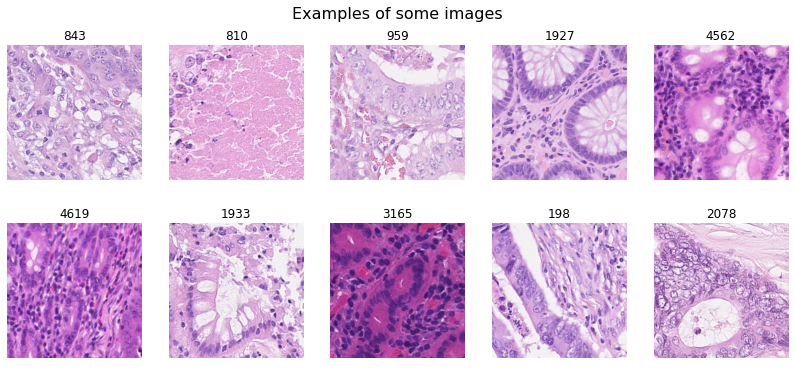

In [5]:
# Creating the figure
fig = plt.figure(figsize=(14, 6))
plt.axes(frame_on=False)
plt.title('Examples of some images', fontsize=16, pad=20)
plt.xticks(())
plt.yticks(())
 
# Creating images
for i in range(1,np.size(ind)+1):
    fig.add_subplot(2, 5, i)
    plt.imshow(X[ind[i-1]])
    plt.axis('off')
    plt.title(ind[i-1])

# Showing the plot
plt.show()    

The numbers above each image represent their index in the dataset. Below we can see the counts of each cell type for the images displayed above.

In [6]:
# Obtaining a table of counts of each cell type for each image above
Y.iloc[ind]

,neutrophil,epithelial,lymphocyte,plasma,eosinophil,connective
843,2,29,16,1,0,50
810,0,5,1,0,0,0
959,0,35,4,0,0,30
1927,0,85,28,9,2,29
4562,1,73,75,6,1,42
4619,1,84,57,8,8,62
1933,0,36,23,0,0,1
3165,0,43,74,9,1,20
198,0,31,17,4,0,38
2078,0,108,0,0,1,0


Looking at the images and the counts of each cell type we can deduce that the T3 (lymphocyte) count corresponds to a number of those purple round-ish blops in the image. Similarly, T5 (eosinophil) count corresponds to pink/redish blops. And so generally the counts correspond to numbers of blops of certain shape, size and color.

### iii.

Now we want to split our data into three folds. We will then plot overlapping (fold-wise) histograms of counts of each cell type. We will use log-scale for better clarity of the plot.

In [7]:
# Obtaining indices for the folds
ind_f1 = np.concatenate(np.argwhere(F==1))
ind_f2 = np.concatenate(np.argwhere(F==2))
ind_f3 = np.concatenate(np.argwhere(F==3))

# Splitting images dataset into corresponding folds
X1 = X[ind_f1]
X2 = X[ind_f2]
X3 = X[ind_f3]

# Splitting cell type counts dataset into corresponding folds
Y1 = Y.iloc[ind_f1]
Y2 = Y.iloc[ind_f2]
Y3 = Y.iloc[ind_f3]

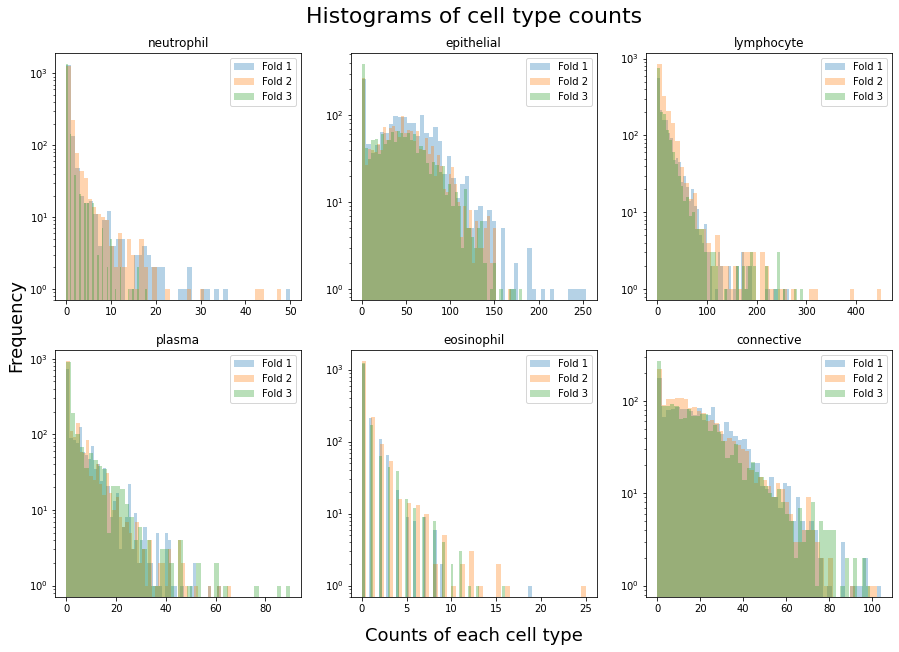

In [8]:
# Create figure
fig = plt.figure(figsize=(15, 10))
plt.axes(frame_on=False)
plt.xticks(())
plt.yticks(())
plt.title(r'Histograms of cell type counts', fontsize = 22, pad=30)
plt.xlabel(r'Counts of each cell type', fontsize=18, labelpad=30)
plt.ylabel(r'Frequency', fontsize = 18, labelpad=30)

# Creating histograms
for i in range(1,7):
    fig.add_subplot(2, 3, i)
    plt.yscale("log")
    plt.hist(Y1.iloc[:, i-1].to_numpy(), bins=50, alpha=0.33, label="Fold 1")
    plt.hist(Y2.iloc[:, i-1].to_numpy(), bins=50, alpha=0.33, label="Fold 2")
    plt.hist(Y3.iloc[:, i-1].to_numpy(), bins=50, alpha=0.33, label="Fold 3")
    plt.title(Y1.columns[i-1])
    plt.legend()

# Showing the plots
plt.show()    

We can see that our data is strongly positively skewed even though we have logged the y-axis. We have relatively few examples of higher counts of each cell type, so predicting higher counts could turn out to be difficult. Further, regression works best with normal data, so this could be a problem as well, we might need to consider a log or square root transformation on the data. Note that the folds are split well as their histograms seem to be fairly similar.

We will now create a table to see how many images have counts within bins of certain size.

In [9]:
# Creating an array of tresholds
tresh = [0,5,10,20,30,40,50]

# Setting a table (dataframe) with an index column
range_table = pd.DataFrame(index=['0', '1-5', '6-10', '11-20', '21-30','31-40','40-50','51+'])

# Obtaining counts of observations for each bin and each cell type
for i in range(0,6):
    unique, counts = np.unique(Y.iloc[:, i], return_counts=True)
    d = {'Count': unique.astype(int), 'Frequency': counts.astype(int)}
    df = pd.DataFrame(data=d)
    v = np.zeros(8)
    v[0] = df.loc[(df['Count'] == tresh[0]), 'Frequency'].sum()
    for j in range(1,np.shape(tresh)[0]):
        v[j] = df.loc[(df['Count'] > tresh[j-1]) & (df['Count'] < tresh[j]+1), 'Frequency'].sum()
    v[7] = df.loc[(df['Count'] > tresh[6]), 'Frequency'].sum()
    range_table[Y.columns[i]] = v.astype(int)
    
# Displaying a table
range_table    

,neutrophil,epithelial,lymphocyte,plasma,eosinophil,connective
0,3912,792,625,1878,3731,454
1-5,867,154,1365,1639,1142,636
6-10,121,145,652,656,91,686
11-20,64,336,888,549,16,1211
21-30,10,435,556,167,1,873
31-40,3,546,312,51,0,534
40-50,4,569,184,25,0,284
51+,0,2004,399,16,0,303


In the table above, a number in row *i*, column *j* corresponds to the number of images that have counts of cell type *j* within bin *i*. 

### iv. 

Now we convert images to HED space from RGB space to explore the H-channel, which should indicate cellular nuclei. First we will take the first image in our data set and see how each channel looks like after conversion to HED space.

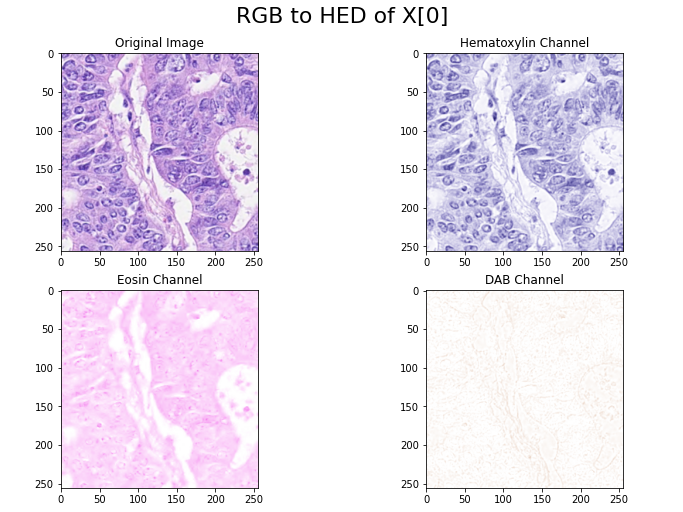

In [10]:
# Converting the first image of the dataset to HED space
I = X[0]
I_hed = rgb2hed(I)

# Creating an RGB image for each of the chanels (so we could see them)
null = np.zeros_like(I_hed[:, :, 0])
I_h = hed2rgb(np.stack((I_hed[:, :, 0], null, null), axis=-1))
I_e = hed2rgb(np.stack((null, I_hed[:, :, 1], null), axis=-1))
I_d = hed2rgb(np.stack((null, null, I_hed[:, :, 2]), axis=-1))

# Creating the figure
fig = plt.figure(figsize=(12, 8))
plt.axes(frame_on=False)
plt.xticks(())
plt.yticks(())
plt.title(r'RGB to HED of X[0]', fontsize = 22, pad=30)

# Original image
fig.add_subplot(2, 2, 1)
plt.imshow(I)
plt.title('Original Image')

# H-channel
fig.add_subplot(2, 2, 2)
plt.imshow(I_h)
plt.title('Hematoxylin Channel')

# E-channel
fig.add_subplot(2, 2, 3)
plt.imshow(I_e)
plt.title('Eosin Channel')

# D-channel
fig.add_subplot(2, 2, 4)
plt.imshow(I_d)
plt.title('DAB Channel')

# Displaying
plt.show()  

So we can see how the image is split into three channels. H-channel produces not only the clearest image, but also the most useful one in predicting the cell type counts as we can see the blops more clearly then before (or compared to other channels). Now we produce 10 examples of the H-channel using the same images we displayed earlier. Again, the numbers above each image represent their index in the dataset. Below we can see the counts of each cell type for the images displayed above.

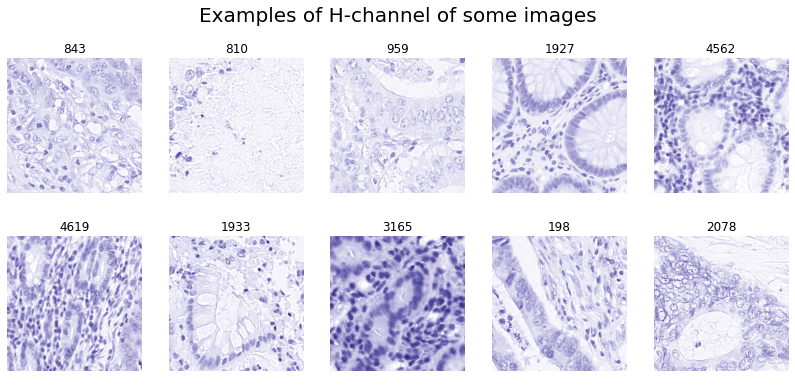

In [11]:
# Create figure
fig = plt.figure(figsize=(14, 6))
plt.axes(frame_on=False)
plt.xticks(())
plt.yticks(())
plt.title('Examples of H-channel of some images', fontsize=20, pad=30)  
 
# Adding images to the main figure
for i in range(1,np.size(ind)+1):
    I = X[ind[i-1]]
    I_hed = rgb2hed(I)
    null = np.zeros_like(I_hed[:, :, 0])
    I_h = hed2rgb(np.stack((I_hed[:, :, 0], null, null), axis=-1))
    fig.add_subplot(2, 5, i)
    plt.imshow(I_h)
    plt.axis('off')
    plt.title(ind[i-1])
    
# Displaying
plt.show()

### v. 

Now we want to explore how the average of the H-channel relates to the cell types. For that we compute the average H-channel for each image in Fold 1 and plot the scatter plots against counts of each cell type.

In [12]:
# Setting the size value and initializing the array to store values
F1_size = np.shape(X1)[0]
avg_h = np.zeros(F1_size)

# Computing the average of the H-channel for each image in Fold 1
for i in range(0, F1_size):
    I_hed = rgb2hed(X[i]) # Converting an image to HED space
    I_h = I_hed[:,:,0] # Retaining H-channel only
    avg_h[i] = np.mean(I_h) # Computing the average

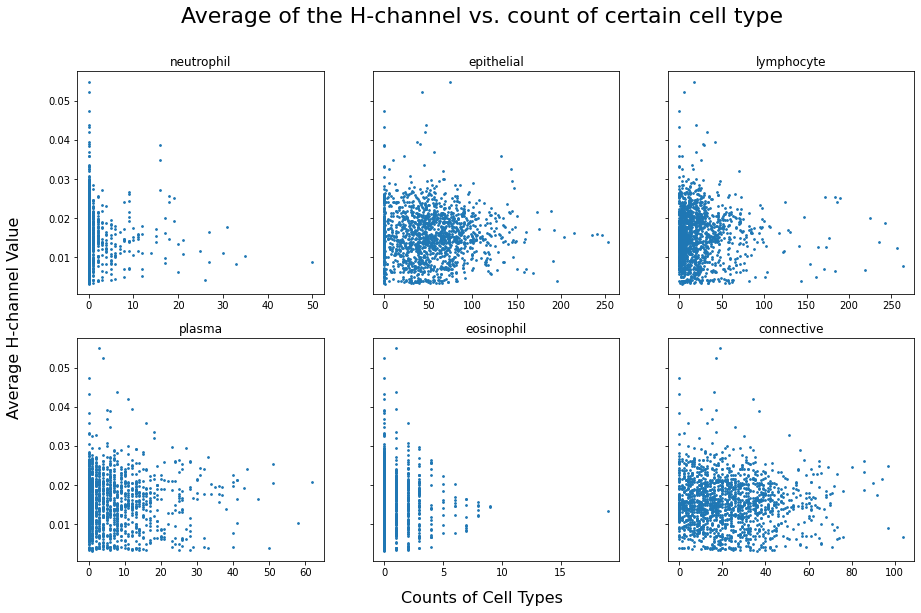

In [13]:
# Creating a figure
fig, axs = plt.subplots(2,3, figsize=(15, 9),sharey=True)
fig.suptitle('Average of the H-channel vs. count of certain cell type', fontsize=22)

# Adding sub-plots
for i in range(0,2):
    for j in range(0,3):
        t = 3*i+j
        counts = Y1.iloc[:, t].to_numpy()
        axs[i,j].scatter(counts,avg_h, s=3)
        axs[i,j].set_title(Y1.columns[t], fontsize = 12)
        
fig.text(0.5, 0.06, 'Counts of Cell Types', ha='center', fontsize = 16)
fig.text(0.06, 0.5, 'Average H-channel Value', va='center', rotation='vertical', fontsize = 16)

# Displaying the scatter plots
plt.show()

This feature does not seem to be very useful in the regression model as there is barely any visible correlation between the average H-channel value of the image and the count of each cell type. We also note that the relationship between the H-channel and counts of cell types in all of the plots does not look linear and there is a lot of heteroskedasticity (the variation on the left side of each plot is greater than on the right side of the plot), but that may be due to fewer observed larger counts of each cell type. However, we can see some patterns, for example, most of the data is clustered in the lower left corner of each scatterplot, but that probably says more about the data, than the potential predictive power of the H-channel. There are some useful obserations, that can be made from these scatter plots, for example, we never observe larger than 0.3 average H-channel value for images with cell type T5 count greater than 5. Similarly, larger (greater than 100) counts of lymphocyte (T3) cell are only observed in images with average H-channel value smaller than 0.25.

### vi.

As we are going to dvelop a regression model, we will be comparing two vectors (or matrices, if we have more than one target variable): one containing predicted values and one containing true values. The metrics that come to mind are MSE, RMSE, MAE, R2-score and correlation coefficients. Due to earlier addressed issues (potential non-linear relationships between features and the target variable; heteroskedasticity; skewness of the data and the target variables), the MAE and MSE would be very biased and affected more by the higher values and the outliers. Note that RMSE is dependent on scaling whilst R2-score is indepedent of scaling R2-score. Because of this, as we do not know yet if we will be scaling the data, we pick the best metric to be R2-score for this problem.

To better understand the regression model we will use R2-score combined with RMSE, Pearson Correlation Coefficient and Spearson Correlation Coefficient.

<center><h2> 2. </h2></center>

For the following part we use only T3 (lymphocyte) type of cells as the output prediction variable. 

In [14]:
# Setting n = the number of observations and initializing the target variable
n = np.shape(X)[0]
target = Y.iloc[:, 2].to_numpy()

### i.

In this part we will extract features from the images, namely the average, the variance and the entropy of the H, red, green and blue channels. First, we define our own entropy function that computes entropy of an image. Then we extract the features and create scatter plots of each feature versus the target variable (T3 lymphocyte cell count). We use the entire dataset for this task.

In [15]:
# Defining entropy function for images
def entropy_mine(image):
    marginal = np.histogramdd(np.ravel(image), bins = 256)[0]/np.size(image)
    marginal = list(filter(lambda p: p > 0, np.ravel(marginal)))
    entropy = -np.sum(np.multiply(marginal, np.log2(marginal)))
    return entropy

In [16]:
# Initializing vectors to store values
avg_h = np.zeros(n) # Average H-Channel values
avg_r = np.zeros(n) # Average R-Channel values
avg_g = np.zeros(n) # Average G-Channel values
avg_b = np.zeros(n) # Average B-Channel values
var_h = np.zeros(n) # Variances of the H-Channel
var_r = np.zeros(n) # Variances of the R-Channel
var_g = np.zeros(n) # Variances of the G-Channel
var_b = np.zeros(n) # Variances of the B-Channel
ent_h = np.zeros(n) # Entropy of the H-Channel
ent_r = np.zeros(n) # Entropy of the R-Channel
ent_g = np.zeros(n) # Entropy of the G-Channel
ent_b = np.zeros(n) # Entropy of the B-Channel

# Computing values
for i in range(0, n):
    I_hed = rgb2hed(X[i]/255.0 ) # Converting normalized RGB to HED space
    I_h = I_hed[:,:,0] # Retaining H-channel
    I_r = X[i][:,:,0]/255 # Retaining normalized R-channel
    I_g = X[i][:,:,1]/255 # Retaining normalized G-channel
    I_b = X[i][:,:,2]/255 # Retaining normalized B-channel
    avg_h[i] = np.mean(I_h) # Computing average of H-channel
    avg_r[i] = np.mean(I_r) # Computing average of R-channel
    avg_g[i] = np.mean(I_g) # Computing average of G-channel
    avg_b[i] = np.mean(I_b) # Computing average of B-channel
    var_h[i] = np.var(I_h) # Computing variance of H-channel
    var_r[i] = np.var(I_r) # Computing variance of R-channel
    var_g[i] = np.var(I_g) # Computing variance of G-channel
    var_b[i] = np.var(I_b) # Computing variance of B-channel
    ent_h[i] = entropy_mine(I_h) #Computing entropy of H-channel
    ent_r[i] = entropy_mine(I_r) #Computing entropy of R-channel
    ent_g[i] = entropy_mine(I_g) #Computing entropy of G-channel
    ent_b[i] = entropy_mine(I_b) #Computing entropy of B-channel

In [17]:
# Storing computed features in array Metrics
metrics = np.array([avg_h, avg_r, avg_g, avg_b, var_h, var_r, var_g, var_b, ent_h, ent_r, ent_g, ent_b])

# Setting colors and names vectors for plotting
colors = np.array(['m','r','g','b'])
names = np.array(['H-channel','R-channel','G-channel','B-channel'])

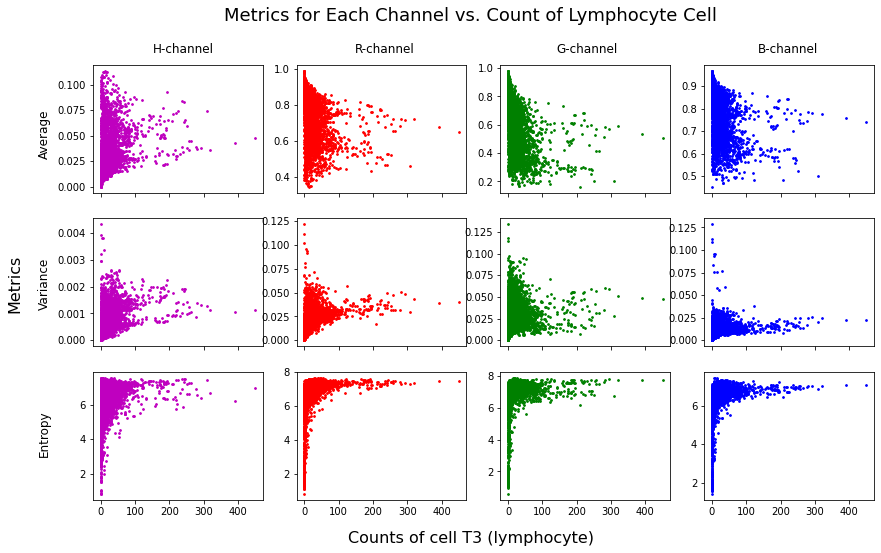

In [18]:
# Creating figure
fig, axs = plt.subplots(3,4, figsize=(14,8), sharex=True) #sharey, sharex
fig.suptitle('Metrics for Each Channel vs. Count of Lymphocyte Cell', fontsize=18)

# Adding scatter plots
for i in range(0,3):
    for j in range(0,4):
        axs[i,j].scatter(target,metrics[4*i+j], s=3, color=colors[j])

# Adding labels
fig.text(0.5, 0.05, 'Counts of cell T3 (lymphocyte)', ha='center', fontsize = 16)
fig.text(0.2-0.015, 0.90, 'H-channel', fontsize = 12)
fig.text(0.4-0.015, 0.90, 'R-channel', fontsize = 12)
fig.text(0.6-0.015, 0.90, 'G-channel', fontsize = 12)
fig.text(0.8-0.015, 0.90, 'B-channel', fontsize = 12)
fig.text(0.04, 0.5, 'Metrics', va='center', rotation='vertical', fontsize = 16)
fig.text(0.07, 0.25-0.01, 'Entropy', va='center', rotation='vertical', fontsize = 12)
fig.text(0.07, 0.5, 'Variance', va='center', rotation='vertical', fontsize = 12)
fig.text(0.07, 0.75+0.01, 'Average', va='center', rotation='vertical', fontsize = 12)

# Display
plt.show()

The averages of each channel would not make great predictors: for small (<100) counts the averages vary over the whole range that they take; for large (>100) values the averages sort of split into two horns. So there does not seem to any kind of relationship between the average channel values and the target variable. The variances are strongly clustered in the left lower corner of the plot, however there is more variability between the channels and we can even see some pattern here, the variance of the blue channel has the clearest relationship with the target variable, but it seems to have the same problems i.e. for small counts the variances vary over the whole range that they take. The entropies all look very similar, the H-channel differs most from the rest of them, the relationsip with the target variable is no where near linear between all of them.

Note that all features seem to have non-linear relationships with the target variable and there is a lot of heteroskedasticity in each feature. Also, the scatter plots are very similar, which implies a lot of collinearity, but that is to be expected, considering that all the features are extracted from the same images just using different channels.

Overall, for small counts NONE of these features would be great for predicting counts smaller than 100. However for counts larger than 100, entropies of all channels might make a good predictor, together with variance of R and B, and possibly H. 

Now we look at the table of correlations between the features and the target variable (counts of lymphocyte cell).

In [19]:
# Initializing the vector to store coefficients
coefs = np.zeros(12)

# Obtaining the correlations
for i in range(0,12):
    coefs[i] = np.corrcoef(metrics[i],target)[0,1]

# Creating and displaying a table
d = {'Average': coefs[0:4], 'Variance':coefs[4:8], 'Entropy': coefs[8:12]}
pd.DataFrame(data=d,index=['H-Channel', 'R-Channel', 'G-Channel', 'B-Channel'])

,Average,Variance,Entropy
H-Channel,0.331016,0.438930,0.312991
R-Channel,-0.360468,0.401639,0.320366
G-Channel,-0.385670,0.128848,0.215746
B-Channel,-0.375746,0.242062,0.287921


After looking at the table of correlations we can see that none of the features are correlated with the target variable enough to be good predictors. We pick the most important features:

- Average of the G-channel
- Variance of the H-channel
- Variance of the R-channel
- Variance of the B-channel
- Entropy of the R-channel
- Entropy of the H-channel

We pick those as we want to have 1-3 features of each category (i.e. Average, Variance, Entropy) and a good mixture of all channels, to retain enough information but not cause too much collinearity. And we picked these particular ones due to relatively higher correlation scores.

Now we will perform PCA to extract more potentially relevant features. Note that PCA algorithm does not run with pictures and even matrices as input thus we will have to reshape them them and resize them (for faster running time) and rescale them (normalize). We will resize images from size $256 \times 256$ to $64 \times 64$, normalize each pixel value and extract channels H,R,G and B as before.

In [20]:
# Initializing dimensions
pixels = 64
rescaled_dim = (pixels,pixels)

# Initializing matrices and vectors to store values
X_resized = np.zeros((n,pixels,pixels,3))
Hs = np.zeros((n,pixels,pixels))
Rs = np.zeros((n,pixels,pixels))
Gs = np.zeros((n,pixels,pixels))
Bs = np.zeros((n,pixels,pixels))
Hs_vector = np.zeros((n, pixels*pixels))
Rs_vector = np.zeros((n, pixels*pixels))
Gs_vector = np.zeros((n, pixels*pixels))
Bs_vector = np.zeros((n, pixels*pixels))

for i in range(0,n):
    # Resizing images to size 64x64
    X_resized[i] = cv2.resize(X[i], dsize = rescaled_dim)
    
    # Extracting channels H, R, G, B and normalizing
    Hs[i] = rgb2hed(X_resized[i]/255)[:,:,0]
    Rs[i] = X_resized[i][:,:,0]/255
    Gs[i] = X_resized[i][:,:,1]/255
    Bs[i] = X_resized[i][:,:,2]/255
    
    # Converting channels H, R, G, B to vectors
    Hs_vector[i] = np.reshape(Hs[i], (1, pixels*pixels))
    Rs_vector[i] = np.reshape(Rs[i], (1, pixels*pixels))
    Gs_vector[i] = np.reshape(Gs[i], (1, pixels*pixels))
    Bs_vector[i] = np.reshape(Bs[i], (1, pixels*pixels))

We now perform PCA with two principal components on each of the channels H, R, G, B and plotting the first two components. We have tried to perform it with different number of components, but there is not much point to do that unless we want to retain hundreds of components so that we preserve a higher percentage of the information.

In [21]:
# Performing PCA
pca = PCA(n_components=2)
pca.fit(Hs_vector)
pca_h = pca.transform(Hs_vector)
pca.fit(Rs_vector)
pca_r = pca.transform(Rs_vector)
pca.fit(Gs_vector)
pca_g = pca.transform(Gs_vector)
pca.fit(Bs_vector)
pca_b = pca.transform(Bs_vector)

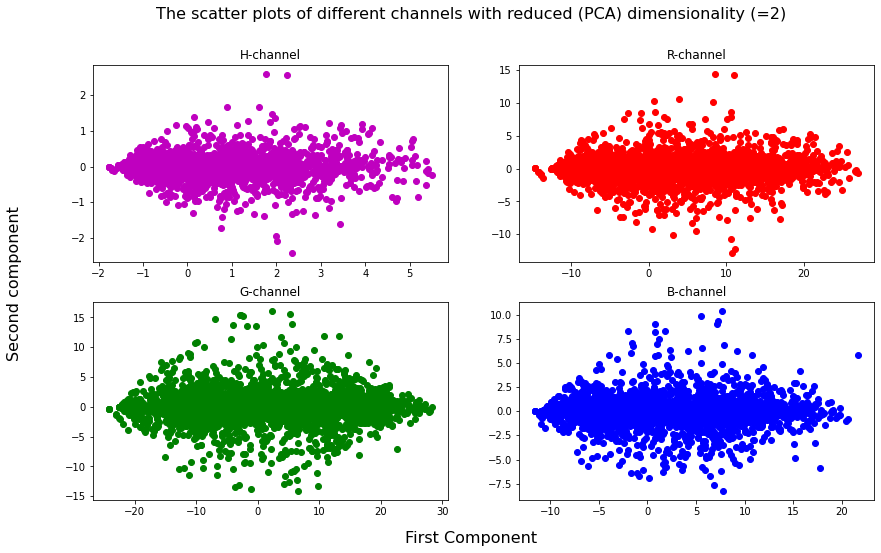

In [22]:
# Creating the figure
fig, axs = plt.subplots(2,2, figsize=(14,8))
fig.suptitle('The scatter plots of different channels with reduced (PCA) dimensionality (=2)', fontsize=16)

# Adding subplots
axs[0,0].scatter(pca_h.T[0], pca_h.T[1], c='m', marker="o")
axs[0,0].set_title(names[0], fontsize = 12)
axs[0,1].scatter(pca_r.T[0], pca_r.T[1], c='r', marker="o")
axs[0,1].set_title(names[1], fontsize = 12)
axs[1,0].scatter(pca_g.T[0], pca_g.T[1], c='g', marker="o")
axs[1,0].set_title(names[2], fontsize = 12)
axs[1,1].scatter(pca_b.T[0], pca_b.T[1], c='b', marker="o")
axs[1,1].set_title(names[3], fontsize = 12)

# Creating labels
fig.text(0.5, 0.05, 'First Component', ha='center', fontsize = 16)
fig.text(0.04, 0.5, 'Second component', va='center', rotation='vertical', fontsize = 16)

# Display
plt.show()

We can clearly see quite a lot of variation in the first component and very little of it in the second component, suggesting that the first component retains much more information that the second one for all channels. Now we look at their correlation matrices.

In [23]:
 # Setting components into an array and initializing a vector to store correlation coefficients
first_comp = np.array([pca_h.T[0],pca_r.T[0],pca_g.T[0],pca_b.T[0]])
second_comp = np.array([pca_h.T[1],pca_r.T[1],pca_g.T[1],pca_b.T[1]])
coefs_pca = np.zeros(8)

# Obtaining correlation coefficients
for i in range(0,4):
    coefs_pca[i] = np.corrcoef(first_comp[i],target)[0,1]
    coefs_pca[i+4] = np.corrcoef(second_comp[i],target)[0,1]
    
# Displaying the table of results
d = {'First Component': coefs_pca[0:4], 'Second Component':coefs_pca[4:8]}
pd.DataFrame(data=d,index=['H-Channel', 'R-Channel', 'G-Channel', 'B-Channel'])

,First Component,Second Component
H-Channel,0.328197,0.024616
R-Channel,0.360406,0.018857
G-Channel,0.385662,-0.000788
B-Channel,0.375774,0.002432


The second component is much less important than the first component as it has essentially no correlation with the target variable. Thus we discard second component for all channels as potential features to be used for regression. Now we look at the scatter plots between the principal components of each channel and the target variable.

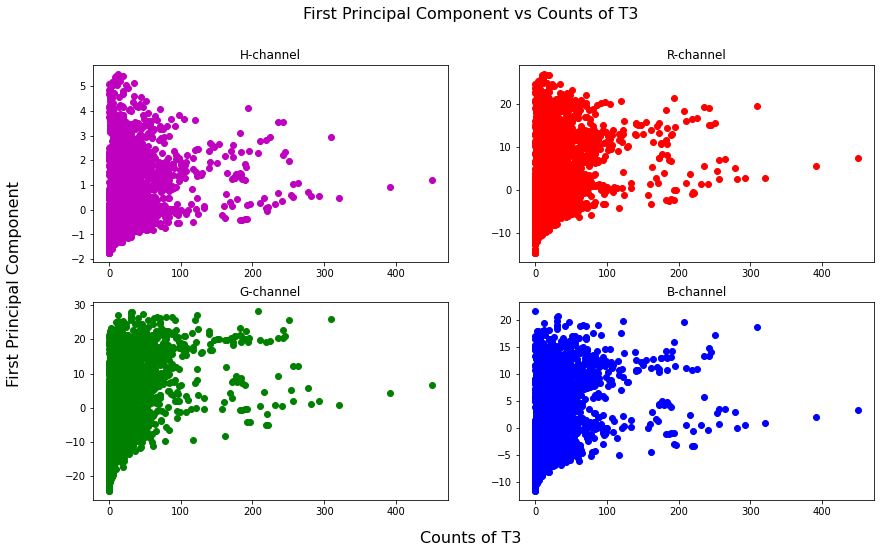

In [24]:
# Creating figure
fig, axs = plt.subplots(2,2, figsize=(14,8))
fig.suptitle('First Principal Component vs Counts of T3', fontsize=16)

# Adding subplots
axs[0,0].scatter(target, pca_h.T[0], c='m', marker="o")
axs[0,0].set_title(names[0], fontsize = 12)
axs[0,1].scatter(target, pca_r.T[0], c='r', marker="o")
axs[0,1].set_title(names[1], fontsize = 12)
axs[1,0].scatter(target, pca_g.T[0], c='g', marker="o")
axs[1,0].set_title(names[2], fontsize = 12)
axs[1,1].scatter(target, pca_b.T[0], c='b', marker="o")
axs[1,1].set_title(names[3], fontsize = 12)

# Adding labels
fig.text(0.5, 0.05, 'Counts of T3', ha='center', fontsize = 16)
fig.text(0.04, 0.5, 'First Principal Component', va='center', rotation='vertical', fontsize = 16)

# Displaying
plt.show()

The scatter plots of the first principal component of all channels look very similar and have similar form as the average of channels. Now we look at the scree plot to see how much variance the components explain. We only plot the scree plot for the H-channel as run time of PCA with a larger number of components is high and the other scree plots look almost exactly the same.

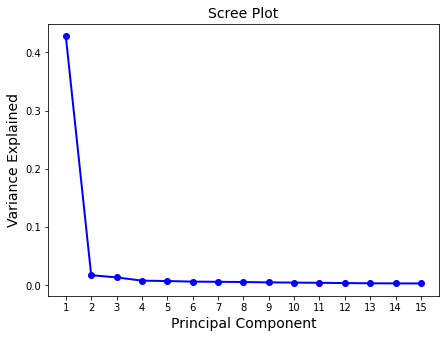

In [25]:
# Scree of the first 15 components
pca = PCA(n_components=15)
pca_fit = pca.fit(Hs_vector)

PC_values = np.arange(pca.n_components_) + 1

plt.rcParams["figure.figsize"] = (7,5)
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot', fontsize=14)
plt.xticks(np.linspace(1,15,15))
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Variance Explained', fontsize=14)
plt.show()

Clearly, as mentioned before, it makes sense to only keep the first principal component, as the rest of them explain very little variance and it would take hundreds of them to retain the standard 95% of information. Note: we have also tried incremental PCA and it had the same results. To summarize this part, the most imporant features are the ones mentioned earlier and the first components for channels H, R, G, B obtained now, which we want to use because they are correlated to the target variable as much as the rest of the features. But that is relative importance, as given the target variable, all the features have very little correlation with the target variable and thus little predictive power.

### ii.

We will perform the regression models with all the features, at risk of having an overfitted model. We will scale the features so that the models perform better. For the training data we use Fold 1 and Fold 2 (combined) and for the test data we use Fold 3.

In [26]:
# Putting all features into one array
features = np.concatenate((metrics,first_comp), axis=0).T

# Scaling the data for better performance of the model
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Setting up the training and testing data
X_train = features[np.concatenate((ind_f1, ind_f2))]
y_train = target[np.concatenate((ind_f1, ind_f2))]
X_test = features[ind_f3]
y_test = target[ind_f3]

#### a) Ordinary Least Squares (OLS) regression

In [27]:
# Fitting the regression
reg = LinearRegression().fit(X_train, y_train)
# Making predictions
y_pred_reg = reg.predict(X_test)

#### b) Support Vector Regression 

In [28]:
#parameters = {'kernel':['linear', 'poly', 'rbf'], 'C':[10, 100, 500, 1000]} 
#reg = GridSearchCV(SVR(), parameters)
#reg.fit(X_train, y_train)
#reg.best_params_

After performing the grid search we have found that the best hyper parameters for SVR are C = 100 and kernel = 'rbf'. The code is commented out as it takes a while to run it.

In [29]:
# Fitting the SVR
svr = SVR(kernel = 'rbf', C = 100).fit(X_train, y_train)
# Making predictions
y_pred_svr = svr.predict(X_test)

#### c) Multilayer Perceptron

In [30]:
#parameters = {'hidden_layer_sizes': [(1,),(2,),(3,),(4,),(1,1),(2,1),(3,1),(4,1),(2,2),(2,3),(3,2)]}
#mlp = MLPRegressor(max_iter=2000, learning_rate = 'adaptive')
#reg = GridSearchCV(mlp, parameters)
#reg.fit(X_train, y_train)
#reg.best_params_

After performing the grid search we have found that the best hyper parameters for MLP are are hidden_layer_sizes = (2,3), activation = 'relu', alpha = 0.0001, learning_rate = 'adaptive'. The code is commented out as it takes a while to run it.

In [31]:
# Fitting the mlp
mlp = MLPRegressor(random_state=1, max_iter=2000, hidden_layer_sizes = (2,3), 
                   alpha = 0.0001, learning_rate = 'adaptive').fit(X_train, y_train)
# Making predictions
y_pred_mlp = mlp.predict(X_test)

Now we compute the scores RMSE, Pearson Correlation, Spearson Correlation and R2-score for each of the regressions.

In [32]:
# Getting the scores
LR_scores = np.array([np.sqrt(mean_squared_error(y_pred_reg, y_test)), stats.pearsonr(y_pred_reg,y_test)[0], stats.spearmanr(y_pred_reg,y_test)[0], r2_score(y_pred_reg,y_test)])
SVR_scores =  np.array([np.sqrt(mean_squared_error(y_pred_svr, y_test)), stats.pearsonr(y_pred_svr,y_test)[0], stats.spearmanr(y_pred_svr,y_test)[0], r2_score(y_pred_svr,y_test)])
MLP_scores =  np.array([np.sqrt(mean_squared_error(y_pred_mlp, y_test)), stats.pearsonr(y_pred_mlp,y_test)[0], stats.spearmanr(y_pred_mlp,y_test)[0], r2_score(y_pred_mlp,y_test)])

# Displaying the table 
d = {'Linear Regression': LR_scores, 'SVR': SVR_scores, 'MLP': MLP_scores}
pd.DataFrame(data=d,index=['RMSE', 'Pearson', 'Spearman', 'R2'])

,Linear Regression,SVR,MLP
RMSE,24.970325,22.901139,25.341968
Pearson,0.642607,0.641807,0.559615
Spearman,0.599497,0.757571,0.667498
R2,0.211023,-1.090726,-0.535999


As expected, since the features have barely any correlation with the target variable, the scores are low, including negative R2-scores which suggest that the model is not fitting the data well at all, but out of these, the simple Linear Regression seems to perform the best (highest R2). Now we plot the scatter plots of predicted and true values for each model.

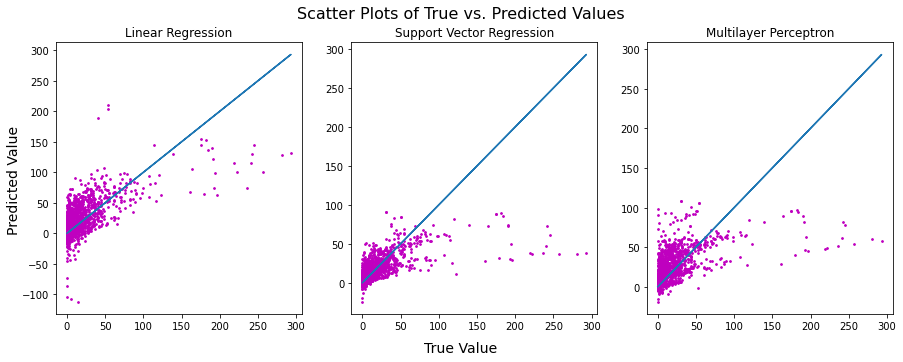

In [33]:
# Creating the figure
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Scatter Plots of True vs. Predicted Values', fontsize=16)

# Adding subplots
axs[0].scatter(y_test, y_pred_reg, c='m', marker="o", s=3)
axs[0].plot(y_test,y_test)
axs[0].set_title('Linear Regression', fontsize = 12)
axs[1].scatter(y_test, y_pred_svr, c='m', marker="o", s=3)
axs[1].plot(y_test,y_test)
axs[1].set_title('Support Vector Regression', fontsize = 12)
axs[2].scatter(y_test, y_pred_mlp, c='m', marker="o", s=3)
axs[2].plot(y_test,y_test)
axs[2].set_title('Multilayer Perceptron', fontsize = 12)

# Adding labels
fig.text(0.5, 0.02, 'True Value', ha='center', fontsize = 14)
fig.text(0.08, 0.5, 'Predicted Value', va='center', rotation='vertical', fontsize = 14)

# Displaying the images
plt.show()

The blue line in the plots represents the perfect model (predicted value = true value). It is now very clear that the all the regression models are performing poorly. This is because the relationship between the data is non-linear and the features do not generalize the data well. After all, how can the average of all the pixels predict the number of certains blops in an image?

<center><h2> 3. </h2></center>

### i. 

In this part we will use a Convolutional Neural Network in keras to perform the regression using images directly as input. For this part we will use resized images (of size $64 \times 64$) as before for better algorithm running time. We split our data into training (Fold 1 and Fold 2) and test (Fold 3). We will try performing the CNN regression with different image inputs, that is: plain resized data ( *X_train*, *X_test* ) and images in HED space instead of RGB ( *X_train_hed*, *X_test_hed* ). Our target variable is, as before, the count of lymphocyte cell T3.

In [81]:
# Setting up training and test data

# Target variable
y_train = target[np.concatenate((ind_f1, ind_f2))]
y_test = target[ind_f3]

# Simple resized data
X_train = X_resized[np.concatenate((ind_f1, ind_f2))]
X_test = X_resized[ind_f3]

# Data in HED space
X_hed = np.zeros_like(X_resized)
for i in range(0, X_resized.shape[0]):
    X_hed[i] = rgb2hed(X_resized[i]/255) 
    
# Data in HED space split for training and testing
X_train_hed = X_hed[np.concatenate((ind_f1, ind_f2))]
X_test_hed = X_hed[ind_f3]

We have tried various models with different numbers of layers, activation function, dense layers, with and without batch normalization, and this is the best performing model we found. Note this model performs best with input images in HED space. We have also tried resnet, but it was very slow and did not converge as fast as this model. So the optimal model has 4 convolutional layers with max pooling each and dropout at the beginning and its input is images converted to HED space.

In [94]:
# Defining the model
optimal = models.Sequential()
optimal.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
optimal.add(layers.MaxPooling2D((2, 2)))
optimal.add(layers.Dropout(0.5)) # Helps mitigate overfitting
optimal.add(layers.Conv2D(64, (3, 3), activation='relu'))
optimal.add(layers.MaxPooling2D((2, 2)))
optimal.add(layers.Conv2D(128, (3, 3), activation='relu'))
optimal.add(layers.MaxPooling2D((2, 2)))
optimal.add(layers.Conv2D(256, (3, 3), activation='relu'))
optimal.add(layers.Flatten())
optimal.add(layers.Dense(128, activation='relu'))
optimal.add(layers.Dense(64, activation='relu')) # To not take out too much information at once
# Relu on last layer since we do not want to have negative cell counts
optimal.add(layers.Dense(1, activation='relu')) # Returning one value i.e. count of cells T3 in this case

# Compiling
optimal.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=['mse'])

# Display the summary
optimal.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 12, 12, 128)      

In [90]:
# Fiting the model with input images converted to HED space
history = optimal.fit(X_train_hed, y_train, epochs=100)

# Making predictions and converting them to suitable formatting (i.e. a vector)
preds_opt = optimal.predict(X_test_hed)
preds_opt = preds_opt.reshape((np.shape(preds_opt)[0],))

Epoch 1/100
106/106 [==============================] - 11s 94ms/step - loss: 864.8633 - mse: 864.8633
Epoch 2/100
106/106 [==============================] - 10s 91ms/step - loss: 695.5868 - mse: 695.5868
Epoch 3/100
106/106 [==============================] - 9s 84ms/step - loss: 565.7048 - mse: 565.7048
Epoch 4/100
106/106 [==============================] - 9s 82ms/step - loss: 532.5840 - mse: 532.5840
Epoch 5/100
106/106 [==============================] - 9s 83ms/step - loss: 423.6419 - mse: 423.6419
Epoch 6/100
106/106 [==============================] - 9s 83ms/step - loss: 423.7021 - mse: 423.7021
Epoch 7/100
106/106 [==============================] - 9s 83ms/step - loss: 384.7351 - mse: 384.7351
Epoch 8/100
106/106 [==============================] - 9s 83ms/step - loss: 351.7434 - mse: 351.7434
Epoch 9/100
106/106 [==============================] - 9s 83ms/step - loss: 310.8430 - mse: 310.8430
Epoch 10/100
106/106 [==============================] - 9s 83ms/step - loss: 305.6536 - m

106/106 [==============================] - 9s 81ms/step - loss: 37.9606 - mse: 37.9606
Epoch 83/100
106/106 [==============================] - 9s 81ms/step - loss: 35.5874 - mse: 35.5874
Epoch 84/100
106/106 [==============================] - 9s 81ms/step - loss: 41.2680 - mse: 41.2680
Epoch 85/100
106/106 [==============================] - 9s 81ms/step - loss: 139.3699 - mse: 139.3699
Epoch 86/100
106/106 [==============================] - 9s 81ms/step - loss: 67.2487 - mse: 67.2487
Epoch 87/100
106/106 [==============================] - 9s 81ms/step - loss: 48.9884 - mse: 48.9884
Epoch 88/100
106/106 [==============================] - 9s 81ms/step - loss: 48.6009 - mse: 48.6009
Epoch 89/100
106/106 [==============================] - 9s 82ms/step - loss: 36.9332 - mse: 36.9332
Epoch 90/100
106/106 [==============================] - 9s 81ms/step - loss: 42.4248 - mse: 42.4248
Epoch 91/100
106/106 [==============================] - 9s 81ms/step - loss: 47.2158 - mse: 47.2158
Epoch 92/10

We now compute the relevant scores for this model.

In [91]:
opt_scores = np.array([np.sqrt(mean_squared_error(preds_opt, y_test)), stats.pearsonr(preds_opt,y_test)[0], stats.spearmanr(preds_opt,y_test)[0], r2_score(preds_opt,y_test)])
d = {'Opt': opt_scores}
pd.DataFrame(data=d,index=['RMSE', 'Pearson', 'Spearman', 'R2'])

,Opt
RMSE,14.223680
Pearson,0.892388
Spearman,0.775602
R2,0.763051


We can see that the scores are pretty great with the reasonably low RMSE and a very good, the best that we have achieved, R2-score, especially compared to the previous regression models. Now we plot the predicted values against the true values to visualize how well the model performs.

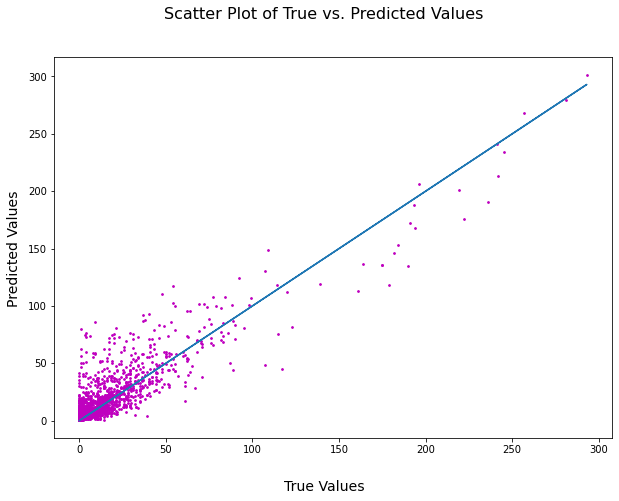

In [92]:
# Creating the figure
fig, axs = plt.subplots(1,1, figsize=(10,7))
fig.suptitle('Scatter Plot of True vs. Predicted Values', fontsize=16)

# Plotting
axs.scatter(y_test, preds_opt, c='m', marker="o", s=3)
axs.plot(y_test,y_test)

# Adding labels
fig.text(0.5, 0.02, 'True Values', ha='center', fontsize = 14)
fig.text(0.06, 0.5, 'Predicted Values', va='center', rotation='vertical', fontsize = 14)

# Displaying
plt.show()

We can see that the linear regression fits the data pretty well (the blue line represents the perfect model i.e. predicted values = true values). Now we plot the convergence plots showing how does loss change over training epochs.

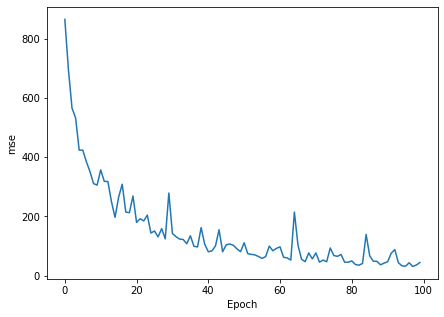

In [93]:
# Plotting
plt.plot(history.history['mse'], label='mse')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.show()

We can clearly see that, while fluctuating, the loss function is decreasing exponentially. In the next part we will use the same model with more epochs for better convergence, see plots below.

### ii. 

In this part we will use 3-Fold cross validation with the previously defined optimal CNN to predict the same target. We will perform this as follows:

- Cross validation fold 1: train and validate on Fold 1 and Fold 2, test on Fold 3
- Cross validation fold 2: train and validate on Fold 1 and Fold 3, test on Fold 2
- Cross validation fold 3: train and validate on Fold 2 and Fold 3, test on Fold 1

In the part "train and validate" we will split the training data (i.e. the two joint folds) into a large part (i.e. $80\%$) for training and the rest(i.e. $20\%$) for validation.

Recall that the input to the model is images of pixels $(64 \times 64)$ in HED space instead of the original $(256 \times 256)$ in RGB.

In [47]:
# Number of epochs
epochs = 200
# Part of data used for validation
part_for_val = 0.2

# Setting the indices for each given fold
indices = [ind_f1, ind_f2, ind_f3]

# Initializing vectors to store the training and validation loss
train_loss_cv = np.zeros((epochs,3))
val_loss_cv = np.zeros((epochs,3)) 

# Initializing vectors to store predictions for each fold of cross validation
preds_1 = np.zeros_like(target[ind_f3])
preds_2 = np.zeros_like(target[ind_f2])
preds_3 = np.zeros_like(target[ind_f1])
predictions = np.array([preds_1, preds_2, preds_3])

# Performing CV 
for i in range(0,2):
    for j in range(i+1,3):
        # Setting the X data (two folds)
        X_train_full = X_hed[np.concatenate((indices[i],indices[j]))]
        
        # Computing the number of images to be used for validation (20% of the training data)
        part = part_for_val*X_train_full.shape[0]
        part = int(part)
        
        # Getting the indices of images to be used for validation
        val_ind = np.random.choice(X_train_full.shape[0], part, replace=False)
        
        # Splitting the X data into training and validation
        X_train = np.delete(X_train_full, val_ind, 0)
        X_val = X_train_full[val_ind]
        # Setting the y data (two folds)
        y_train_full = target[np.concatenate((indices[i],indices[j]))]
        # Splitting the y data into training and validation
        y_train = np.delete(y_train_full, val_ind, 0)
        y_val = y_train_full[val_ind]
        # Setting the test data (remaining one fold)
        X_test = X_hed[indices[3-i-j]]
        y_test = target[indices[3-i-j]]

        
        # Recompiling the model so it doesn't carry on training from the previous CV
        optimal.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=['mse'])
        
        # Fitting the data
        history = optimal.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size = 16)
        
        # Obtaining the training and validation loss for each fold
        train_loss_cv[:,i+j-1] = history.history['mse']        
        val_loss_cv[:,i+j-1] = history.history['val_mse']
        
        # Making predictions and storing them in a suitable format (i.e. vector)
        predictions[i+j-1] = optimal.predict(X_test)
        predictions[i+j-1] = predictions[i+j-1].reshape((np.shape(predictions[i+j-1])[0],))

/home/nshkeir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/200
169/169 [==============================] - 9s 50ms/step - loss: 129.2033 - mse: 129.2033 - val_loss: 551.3423 - val_mse: 551.3423
Epoch 2/200
169/169 [==============================] - 8s 49ms/step - loss: 179.5355 - mse: 179.5355 - val_loss: 86.2546 - val_mse: 86.2546
Epoch 3/200
169/169 [==============================] - 8s 50ms/step - loss: 73.2014 - mse: 73.2014 - val_loss: 61.8776 - val_mse: 61.8776
Epoch 4/200
169/169 [==============================] - 8s 49ms/step - loss: 213.7926 - mse: 213.7926 - val_loss: 162.3241 - val_mse: 162.3241
Epoch 5/200
169/169 [==============================] - 8s 49ms/step - loss: 150.2153 - mse: 150.2153 - val_loss: 111.4328 - val_mse: 111.4328
Epoch 6/200
169/169 [==============================] - 8s 49ms/step - loss: 104.4192 - mse: 104.4192 - val_loss: 168.7068 - val_mse: 168.7068
Epoch 7/200
169/169 [==============================] - 8s 49ms/step - loss: 72.4007 - mse: 72.4007 - val_loss: 145.0444 - val_mse: 145.0444
Epoch 8/200
16

169/169 [==============================] - 8s 49ms/step - loss: 46.6401 - mse: 46.6401 - val_loss: 117.2814 - val_mse: 117.2814
Epoch 118/200
169/169 [==============================] - 8s 49ms/step - loss: 26.4636 - mse: 26.4636 - val_loss: 198.1075 - val_mse: 198.1075
Epoch 119/200
169/169 [==============================] - 8s 49ms/step - loss: 22.1441 - mse: 22.1441 - val_loss: 167.9035 - val_mse: 167.9035
Epoch 120/200
169/169 [==============================] - 8s 49ms/step - loss: 23.8662 - mse: 23.8662 - val_loss: 155.1640 - val_mse: 155.1640
Epoch 121/200
169/169 [==============================] - 8s 49ms/step - loss: 42.0235 - mse: 42.0235 - val_loss: 213.2128 - val_mse: 213.2128
Epoch 122/200
169/169 [==============================] - 8s 49ms/step - loss: 28.8540 - mse: 28.8540 - val_loss: 172.6621 - val_mse: 172.6621
Epoch 123/200
169/169 [==============================] - 8s 49ms/step - loss: 24.0445 - mse: 24.0445 - val_loss: 179.9380 - val_mse: 179.9380
Epoch 124/200
169/16

Epoch 175/200
169/169 [==============================] - 8s 49ms/step - loss: 20.0628 - mse: 20.0628 - val_loss: 159.4426 - val_mse: 159.4426
Epoch 176/200
169/169 [==============================] - 8s 49ms/step - loss: 16.2092 - mse: 16.2092 - val_loss: 151.8890 - val_mse: 151.8890
Epoch 177/200
169/169 [==============================] - 8s 49ms/step - loss: 20.3431 - mse: 20.3431 - val_loss: 160.9773 - val_mse: 160.9773
Epoch 178/200
169/169 [==============================] - 8s 49ms/step - loss: 11.1123 - mse: 11.1123 - val_loss: 159.7081 - val_mse: 159.7081
Epoch 179/200
169/169 [==============================] - 8s 49ms/step - loss: 17.0519 - mse: 17.0519 - val_loss: 134.5634 - val_mse: 134.5634
Epoch 180/200
169/169 [==============================] - 8s 48ms/step - loss: 15.5682 - mse: 15.5682 - val_loss: 171.1454 - val_mse: 171.1454
Epoch 181/200
169/169 [==============================] - 8s 48ms/step - loss: 13.2636 - mse: 13.2636 - val_loss: 150.5026 - val_mse: 150.5026
Epoch 

162/162 [==============================] - 8s 48ms/step - loss: 12.8477 - mse: 12.8477 - val_loss: 68.4676 - val_mse: 68.4676
Epoch 93/200
162/162 [==============================] - 8s 49ms/step - loss: 12.7587 - mse: 12.7587 - val_loss: 69.6134 - val_mse: 69.6134
Epoch 94/200
162/162 [==============================] - 8s 49ms/step - loss: 11.2805 - mse: 11.2805 - val_loss: 74.8554 - val_mse: 74.8554
Epoch 95/200
162/162 [==============================] - 8s 49ms/step - loss: 9.7327 - mse: 9.7327 - val_loss: 72.8560 - val_mse: 72.8560
Epoch 96/200
162/162 [==============================] - 8s 49ms/step - loss: 10.9372 - mse: 10.9372 - val_loss: 78.7932 - val_mse: 78.7932
Epoch 97/200
162/162 [==============================] - 8s 48ms/step - loss: 17.7378 - mse: 17.7378 - val_loss: 68.7306 - val_mse: 68.7306
Epoch 98/200
162/162 [==============================] - 8s 48ms/step - loss: 10.9868 - mse: 10.9868 - val_loss: 68.5498 - val_mse: 68.5498
Epoch 99/200
162/162 [====================

168/168 [==============================] - 8s 48ms/step - loss: 27.4784 - mse: 27.4784 - val_loss: 70.2094 - val_mse: 70.2094
Epoch 11/200
168/168 [==============================] - 8s 48ms/step - loss: 20.9591 - mse: 20.9591 - val_loss: 62.3868 - val_mse: 62.3868
Epoch 12/200
168/168 [==============================] - 8s 48ms/step - loss: 17.3837 - mse: 17.3837 - val_loss: 79.7688 - val_mse: 79.7688
Epoch 13/200
168/168 [==============================] - 8s 48ms/step - loss: 14.1268 - mse: 14.1268 - val_loss: 64.7214 - val_mse: 64.7214
Epoch 14/200
168/168 [==============================] - 8s 48ms/step - loss: 24.3470 - mse: 24.3470 - val_loss: 71.7585 - val_mse: 71.7585
Epoch 15/200
168/168 [==============================] - 8s 49ms/step - loss: 17.3287 - mse: 17.3287 - val_loss: 60.2166 - val_mse: 60.2166
Epoch 16/200
168/168 [==============================] - 8s 49ms/step - loss: 12.0238 - mse: 12.0238 - val_loss: 38.3580 - val_mse: 38.3580
Epoch 17/200
168/168 [==================

168/168 [==============================] - 8s 48ms/step - loss: 8.0305 - mse: 8.0305 - val_loss: 90.8069 - val_mse: 90.8069
Epoch 129/200
168/168 [==============================] - 8s 48ms/step - loss: 9.0660 - mse: 9.0660 - val_loss: 110.3994 - val_mse: 110.3994
Epoch 130/200
168/168 [==============================] - 8s 48ms/step - loss: 8.0847 - mse: 8.0847 - val_loss: 107.5519 - val_mse: 107.5519
Epoch 131/200
168/168 [==============================] - 8s 48ms/step - loss: 5.3662 - mse: 5.3662 - val_loss: 86.0189 - val_mse: 86.0189
Epoch 132/200
168/168 [==============================] - 8s 48ms/step - loss: 10.4158 - mse: 10.4158 - val_loss: 73.4267 - val_mse: 73.4267
Epoch 133/200
168/168 [==============================] - 8s 49ms/step - loss: 5.2839 - mse: 5.2839 - val_loss: 72.3375 - val_mse: 72.3375
Epoch 134/200
168/168 [==============================] - 8s 48ms/step - loss: 7.2187 - mse: 7.2187 - val_loss: 92.6026 - val_mse: 92.6026
Epoch 135/200
168/168 [===================

168/168 [==============================] - 8s 48ms/step - loss: 8.7251 - mse: 8.7251 - val_loss: 113.3046 - val_mse: 113.3046
Epoch 188/200
168/168 [==============================] - 8s 48ms/step - loss: 4.0007 - mse: 4.0007 - val_loss: 95.5499 - val_mse: 95.5499
Epoch 189/200
168/168 [==============================] - 8s 48ms/step - loss: 5.7657 - mse: 5.7657 - val_loss: 101.0798 - val_mse: 101.0798
Epoch 190/200
168/168 [==============================] - 8s 48ms/step - loss: 6.2272 - mse: 6.2272 - val_loss: 125.1748 - val_mse: 125.1748
Epoch 191/200
168/168 [==============================] - 8s 48ms/step - loss: 4.7888 - mse: 4.7888 - val_loss: 92.6147 - val_mse: 92.6147
Epoch 192/200
168/168 [==============================] - 8s 49ms/step - loss: 7.2068 - mse: 7.2068 - val_loss: 91.6421 - val_mse: 91.6421
Epoch 193/200
168/168 [==============================] - 8s 48ms/step - loss: 4.0824 - mse: 4.0824 - val_loss: 115.3762 - val_mse: 115.3762
Epoch 194/200
168/168 [=================

Now we compute the scores for each fold in the performed cross validation.

In [48]:
# Obtaining scores
scores1 = np.array([np.sqrt(mean_squared_error(predictions[0], target[ind_f3])), stats.pearsonr(predictions[0],target[ind_f3])[0], stats.spearmanr(predictions[0],target[ind_f3])[0], r2_score(predictions[0],target[ind_f3])])
scores2 = np.array([np.sqrt(mean_squared_error(predictions[1], target[ind_f2])), stats.pearsonr(predictions[1],target[ind_f2])[0], stats.spearmanr(predictions[1],target[ind_f2])[0], r2_score(predictions[1],target[ind_f2])])
scores3 = np.array([np.sqrt(mean_squared_error(predictions[2], target[ind_f1])), stats.pearsonr(predictions[2],target[ind_f1])[0], stats.spearmanr(predictions[2],target[ind_f1])[0], r2_score(predictions[2],target[ind_f1])])

# Obtaining the average of scores across folds
average_scores = np.mean([scores1,scores2,scores3],axis = 0)

# Creating and displaying a table of score
d = {'Test is F3': scores1,'Test is F2': scores2,'Test is F1': scores3,'Average': average_scores}
pd.DataFrame(data=d,index=['RMSE', 'Pearson', 'Spearman', 'R2'])

,Test is F3,Test is F2,Test is F1,Average
RMSE,16.227294,17.348524,7.646787,13.740868
Pearson,0.838411,0.903372,0.971174,0.904319
Spearman,0.751154,0.866764,0.917900,0.845272
R2,0.512329,0.280201,0.908937,0.567156


Now we plot the training and validation losses of the cross validation for this model.

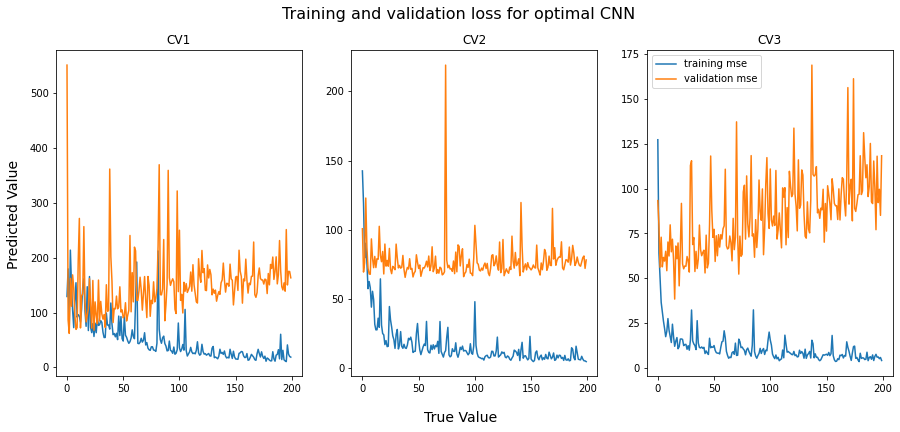

In [50]:
# Create figure
fig, axs = plt.subplots(1,3, figsize=(15,6))
fig.suptitle('Training and validation loss for optimal CNN ', fontsize=16)

# Add subplots
axs[0].plot(train_loss_cv[:,0], label='training mse')
axs[0].plot(val_loss_cv[:,0], label='validation mse')
axs[0].set_title('CV1', fontsize = 12)
axs[1].plot(train_loss_cv[:,1], label='training mse')
axs[1].plot(val_loss_cv[:,1], label='validation mse')
axs[1].set_title('CV2', fontsize = 12)
axs[2].plot(train_loss_cv[:,2], label='training mse')
axs[2].plot(val_loss_cv[:,2], label='validation mse')
axs[2].set_title('CV3', fontsize = 12)

# Add labels and legend
plt.legend()
fig.text(0.5, 0.02, 'True Value', ha='center', fontsize = 14)
fig.text(0.08, 0.5, 'Predicted Value', va='center', rotation='vertical', fontsize = 14)

# Display
plt.show()

The loss is for training is decreasing as expected, the cross validation loss implies overfitting.

Now we plot the predicted values against the true values for each of the folds in the cross validation. The blue line, as before, corresponds to the perfect model, where predicted values = true values.

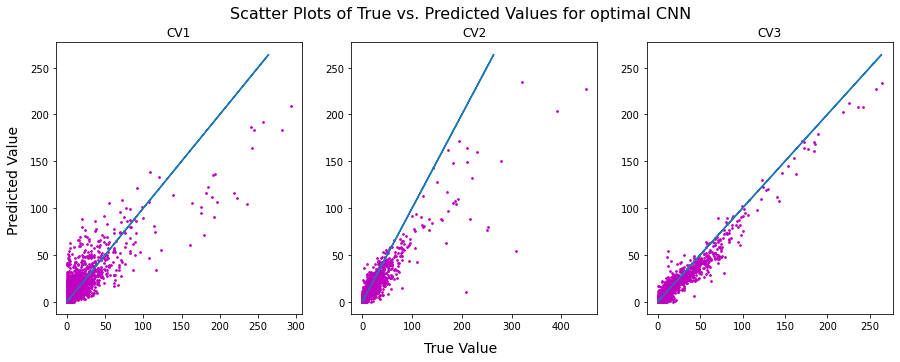

In [51]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Scatter Plots of True vs. Predicted Values for optimal CNN', fontsize=16)

axs[0].scatter(target[ind_f3], predictions[0], c='m', marker="o", s=3)
axs[0].plot(y_test,y_test)
axs[0].set_title('CV1', fontsize = 12)
axs[1].scatter(target[ind_f2], predictions[1], c='m', marker="o", s=3)
axs[1].plot(y_test,y_test)
axs[1].set_title('CV2', fontsize = 12)
axs[2].scatter(target[ind_f1], predictions[2], c='m', marker="o", s=3)
axs[2].plot(y_test,y_test)
axs[2].set_title('CV3', fontsize = 12)

fig.text(0.5, 0.02, 'True Value', ha='center', fontsize = 14)
fig.text(0.08, 0.5, 'Predicted Value', va='center', rotation='vertical', fontsize = 14)

plt.show()

The models fit the data reasonably well.

### iii.

For predicting the cell counts of all 6 cells, we decided on importing a popular pre-built CNN with no weights and changing the input layers as well as adding a dense layer of dimension = 6 as the output. We chose the resnet50V2 since it is faster to train than resnet50 and perfroms better in the literature. However, as results below show, this model is not good for this task and due to the time limits of this project, it has not been improved or finished, unfortunately.

In [52]:
# Building the model
input_img = keras.Input(shape = (64,64,3))

resnet  = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights=None,
    pooling='max',
)(input_img)


activation = keras.layers.Activation("relu")(resnet)
output = keras.layers.Dense(6)(activation)

resnet_cv = keras.Model(input_img,output)

In [53]:
# Summary of the model
resnet_cv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 activation (Activation)     (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23,577,094
Trainable params: 23,531,654
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
# Number of epochs
epochs = 50
# Part of data used for validation
part_for_val = 0.2

# Setting the indices for each given fold
indices = [ind_f1, ind_f2, ind_f3]

# Initializing vectors to store the training and validation loss
train_loss_cv = np.zeros((epochs,3))
val_loss_cv = np.zeros((epochs,3)) 

# Initializing vectors to store predictions for each fold of cross validation
preds_1 = np.zeros_like(Y3.to_numpy())
preds_2 = np.zeros_like(Y2.to_numpy())
preds_3 = np.zeros_like(Y1.to_numpy())
predictions = np.array([preds_1, preds_2, preds_3])

# Performing CV 
for i in range(0,2):
    for j in range(i+1,3):
        # Setting the X data (two folds)
        X_train_full = X_hed[np.concatenate((indices[i],indices[j]))]
        
        # Computing the number of images to be used for validation (20% of the training data)
        part = part_for_val*X_train_full.shape[0]
        part = int(part)
        
        # Getting the indices of images to be used for validation
        val_ind = np.random.choice(X_train_full.shape[0], part, replace=False)
        
        # Splitting the X data into training and validation
        X_train = np.delete(X_train_full, val_ind, 0)
        X_val = X_train_full[val_ind]
        # Setting the y data (two folds)
        y_train_full = Y.to_numpy()[np.concatenate((indices[i],indices[j]))]
        # Splitting the y data into training and validation
        y_train = np.delete(y_train_full, val_ind, 0)
        y_val = y_train_full[val_ind]
        # Setting the test data (remaining one fold)
        X_test = X_hed[indices[3-i-j]]
        y_test = Y.to_numpy()[indices[3-i-j]]

        
        # Recompiling the model so it doesn't carry on training from the previous CV
        resnet  = tf.keras.applications.ResNet50V2(
            include_top=False,
            weights=None,
            pooling='max',
            )(input_img)


        activation = keras.layers.Activation("relu")(resnet)
        output = keras.layers.Dense(6)(activation)

        resnet_cv = keras.Model(input_img,output)
        
        resnet_cv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=['mse'])
        
        # Fitting the data
        history = resnet_cv.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size = 16)
        
        # Obtaining the training and validation loss for each fold
        train_loss_cv[:,i+j-1] = history.history['mse']        
        val_loss_cv[:,i+j-1] = history.history['val_mse']
        
        # Making predictions and storing them in a suitable format
        predictions[i+j-1] = resnet_cv.predict(X_test)

In [ ]:
# Obtaining scores for T1 cell
i=0
scores1 = np.array([np.sqrt(mean_squared_error(predictions[0].T[i], Y3.to_numpy().T[i])), stats.pearsonr(predictions[0].T[i],Y3.to_numpy().T[i])[0], stats.spearmanr(predictions[0].T[i],Y3.to_numpy().T[i])[0], r2_score(predictions[0].T[i],Y3.to_numpy().T[i])])
scores2 = np.array([np.sqrt(mean_squared_error(predictions[1].T[i], Y2.to_numpy().T[i])), stats.pearsonr(predictions[1].T[i],Y2.to_numpy().T[i])[0], stats.spearmanr(predictions[1].T[i],Y2.to_numpy().T[i])[0], r2_score(predictions[1].T[i],Y2.to_numpy().T[i])])
scores3 = np.array([np.sqrt(mean_squared_error(predictions[2].T[i], Y1.to_numpy().T[i])), stats.pearsonr(predictions[2].T[i],Y1.to_numpy().T[i])[0], stats.spearmanr(predictions[2].T[i],Y1.to_numpy().T[i])[0], r2_score(predictions[2].T[i],Y1.to_numpy().T[i])])

# Obtaining the average of scores across folds
average_scores = np.mean([scores1,scores2,scores3],axis = 0)

# Creating and displaying a table of score
d = {'CV1 (test on F3)': scores1,'CV2 (test on F2)': scores2,'CV3 (test on F1)': scores3,'Average': average_scores}
pd.DataFrame(data=d,index=['RMSE', 'Pearson', 'Spearman', 'R2'])

In [ ]:
# Obtaining scores for T2 cell
i=1
scores1 = np.array([np.sqrt(mean_squared_error(predictions[0].T[i], Y3.to_numpy().T[i])), stats.pearsonr(predictions[0].T[i],Y3.to_numpy().T[i])[0], stats.spearmanr(predictions[0].T[i],Y3.to_numpy().T[i])[0], r2_score(predictions[0].T[i],Y3.to_numpy().T[i])])
scores2 = np.array([np.sqrt(mean_squared_error(predictions[1].T[i], Y2.to_numpy().T[i])), stats.pearsonr(predictions[1].T[i],Y2.to_numpy().T[i])[0], stats.spearmanr(predictions[1].T[i],Y2.to_numpy().T[i])[0], r2_score(predictions[1].T[i],Y2.to_numpy().T[i])])
scores3 = np.array([np.sqrt(mean_squared_error(predictions[2].T[i], Y1.to_numpy().T[i])), stats.pearsonr(predictions[2].T[i],Y1.to_numpy().T[i])[0], stats.spearmanr(predictions[2].T[i],Y1.to_numpy().T[i])[0], r2_score(predictions[2].T[i],Y1.to_numpy().T[i])])

# Obtaining the average of scores across folds
average_scores = np.mean([scores1,scores2,scores3],axis = 0)

# Creating and displaying a table of score
d = {'CV1 (test on F3)': scores1,'CV2 (test on F2)': scores2,'CV3 (test on F1)': scores3,'Average': average_scores}
pd.DataFrame(data=d,index=['RMSE', 'Pearson', 'Spearman', 'R2'])

In [ ]:
# Obtaining scores for T3 cell
i=2
scores1 = np.array([np.sqrt(mean_squared_error(predictions[0].T[i], Y3.to_numpy().T[i])), stats.pearsonr(predictions[0].T[i],Y3.to_numpy().T[i])[0], stats.spearmanr(predictions[0].T[i],Y3.to_numpy().T[i])[0], r2_score(predictions[0].T[i],Y3.to_numpy().T[i])])
scores2 = np.array([np.sqrt(mean_squared_error(predictions[1].T[i], Y2.to_numpy().T[i])), stats.pearsonr(predictions[1].T[i],Y2.to_numpy().T[i])[0], stats.spearmanr(predictions[1].T[i],Y2.to_numpy().T[i])[0], r2_score(predictions[1].T[i],Y2.to_numpy().T[i])])
scores3 = np.array([np.sqrt(mean_squared_error(predictions[2].T[i], Y1.to_numpy().T[i])), stats.pearsonr(predictions[2].T[i],Y1.to_numpy().T[i])[0], stats.spearmanr(predictions[2].T[i],Y1.to_numpy().T[i])[0], r2_score(predictions[2].T[i],Y1.to_numpy().T[i])])

# Obtaining the average of scores across folds
average_scores = np.mean([scores1,scores2,scores3],axis = 0)

# Creating and displaying a table of score
d = {'CV1 (test on F3)': scores1,'CV2 (test on F2)': scores2,'CV3 (test on F1)': scores3,'Average': average_scores}
pd.DataFrame(data=d,index=['RMSE', 'Pearson', 'Spearman', 'R2'])

In [ ]:
# Obtaining scores for T4 cell
i=3
scores1 = np.array([np.sqrt(mean_squared_error(predictions[0].T[i], Y3.to_numpy().T[i])), stats.pearsonr(predictions[0].T[i],Y3.to_numpy().T[i])[0], stats.spearmanr(predictions[0].T[i],Y3.to_numpy().T[i])[0], r2_score(predictions[0].T[i],Y3.to_numpy().T[i])])
scores2 = np.array([np.sqrt(mean_squared_error(predictions[1].T[i], Y2.to_numpy().T[i])), stats.pearsonr(predictions[1].T[i],Y2.to_numpy().T[i])[0], stats.spearmanr(predictions[1].T[i],Y2.to_numpy().T[i])[0], r2_score(predictions[1].T[i],Y2.to_numpy().T[i])])
scores3 = np.array([np.sqrt(mean_squared_error(predictions[2].T[i], Y1.to_numpy().T[i])), stats.pearsonr(predictions[2].T[i],Y1.to_numpy().T[i])[0], stats.spearmanr(predictions[2].T[i],Y1.to_numpy().T[i])[0], r2_score(predictions[2].T[i],Y1.to_numpy().T[i])])

# Obtaining the average of scores across folds
average_scores = np.mean([scores1,scores2,scores3],axis = 0)

# Creating and displaying a table of score
d = {'CV1 (test on F3)': scores1,'CV2 (test on F2)': scores2,'CV3 (test on F1)': scores3,'Average': average_scores}
pd.DataFrame(data=d,index=['RMSE', 'Pearson', 'Spearman', 'R2'])

In [ ]:
# Obtaining scores for T5 cell
i=4
scores1 = np.array([np.sqrt(mean_squared_error(predictions[0].T[i], Y3.to_numpy().T[i])), stats.pearsonr(predictions[0].T[i],Y3.to_numpy().T[i])[0], stats.spearmanr(predictions[0].T[i],Y3.to_numpy().T[i])[0], r2_score(predictions[0].T[i],Y3.to_numpy().T[i])])
scores2 = np.array([np.sqrt(mean_squared_error(predictions[1].T[i], Y2.to_numpy().T[i])), stats.pearsonr(predictions[1].T[i],Y2.to_numpy().T[i])[0], stats.spearmanr(predictions[1].T[i],Y2.to_numpy().T[i])[0], r2_score(predictions[1].T[i],Y2.to_numpy().T[i])])
scores3 = np.array([np.sqrt(mean_squared_error(predictions[2].T[i], Y1.to_numpy().T[i])), stats.pearsonr(predictions[2].T[i],Y1.to_numpy().T[i])[0], stats.spearmanr(predictions[2].T[i],Y1.to_numpy().T[i])[0], r2_score(predictions[2].T[i],Y1.to_numpy().T[i])])

# Obtaining the average of scores across folds
average_scores = np.mean([scores1,scores2,scores3],axis = 0)

# Creating and displaying a table of score
d = {'CV1 (test on F3)': scores1,'CV2 (test on F2)': scores2,'CV3 (test on F1)': scores3,'Average': average_scores}
pd.DataFrame(data=d,index=['RMSE', 'Pearson', 'Spearman', 'R2'])

In [ ]:
# Obtaining scores for T6 cell
i=5
scores1 = np.array([np.sqrt(mean_squared_error(predictions[0].T[i], Y3.to_numpy().T[i])), stats.pearsonr(predictions[0].T[i],Y3.to_numpy().T[i])[0], stats.spearmanr(predictions[0].T[i],Y3.to_numpy().T[i])[0], r2_score(predictions[0].T[i],Y3.to_numpy().T[i])])
scores2 = np.array([np.sqrt(mean_squared_error(predictions[1].T[i], Y2.to_numpy().T[i])), stats.pearsonr(predictions[1].T[i],Y2.to_numpy().T[i])[0], stats.spearmanr(predictions[1].T[i],Y2.to_numpy().T[i])[0], r2_score(predictions[1].T[i],Y2.to_numpy().T[i])])
scores3 = np.array([np.sqrt(mean_squared_error(predictions[2].T[i], Y1.to_numpy().T[i])), stats.pearsonr(predictions[2].T[i],Y1.to_numpy().T[i])[0], stats.spearmanr(predictions[2].T[i],Y1.to_numpy().T[i])[0], r2_score(predictions[2].T[i],Y1.to_numpy().T[i])])

# Obtaining the average of scores across folds
average_scores = np.mean([scores1,scores2,scores3],axis = 0)

# Creating and displaying a table of score
d = {'CV1 (test on F3)': scores1,'CV2 (test on F2)': scores2,'CV3 (test on F1)': scores3,'Average': average_scores}
pd.DataFrame(data=d,index=['RMSE', 'Pearson', 'Spearman', 'R2'])

In [ ]:
# Creating figure for T1 cell
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Scatter Plots of True vs. Predicted Values for T1 cell', fontsize=16)

i=0
# Adding subplots
axs[0].scatter(Y3.to_numpy().T[i], predictions[0].T[i], c='m', marker="o", s=3)
axs[0].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[0].set_title('CV1', fontsize = 12)
axs[1].scatter(Y2.to_numpy().T[i], predictions[1].T[i], c='m', marker="o", s=3)
axs[1].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[1].set_title('CV2', fontsize = 12)
axs[2].scatter(Y1.to_numpy().T[i], predictions[2].T[i], c='m', marker="o", s=3)
axs[2].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[2].set_title('CV3', fontsize = 12)

# Adding labels
fig.text(0.5, 0.02, 'True Value', ha='center', fontsize = 14)
fig.text(0.08, 0.5, 'Predicted Value', va='center', rotation='vertical', fontsize = 14)

# Display
plt.show()

In [ ]:
# Creating figure for T2 cell
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Scatter Plots of True vs. Predicted Values for T1 cell', fontsize=16)

i=1
# Adding subplots
axs[0].scatter(Y3.to_numpy().T[i], predictions[0].T[i], c='m', marker="o", s=3)
axs[0].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[0].set_title('CV1', fontsize = 12)
axs[1].scatter(Y2.to_numpy().T[i], predictions[1].T[i], c='m', marker="o", s=3)
axs[1].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[1].set_title('CV2', fontsize = 12)
axs[2].scatter(Y1.to_numpy().T[i], predictions[2].T[i], c='m', marker="o", s=3)
axs[2].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[2].set_title('CV3', fontsize = 12)

# Adding labels
fig.text(0.5, 0.02, 'True Value', ha='center', fontsize = 14)
fig.text(0.08, 0.5, 'Predicted Value', va='center', rotation='vertical', fontsize = 14)

# Display
plt.show()

In [ ]:
# Creating figure for T3 cell
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Scatter Plots of True vs. Predicted Values for T1 cell', fontsize=16)

i=2
# Adding subplots
axs[0].scatter(Y3.to_numpy().T[i], predictions[0].T[i], c='m', marker="o", s=3)
axs[0].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[0].set_title('CV1', fontsize = 12)
axs[1].scatter(Y2.to_numpy().T[i], predictions[1].T[i], c='m', marker="o", s=3)
axs[1].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[1].set_title('CV2', fontsize = 12)
axs[2].scatter(Y1.to_numpy().T[i], predictions[2].T[i], c='m', marker="o", s=3)
axs[2].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[2].set_title('CV3', fontsize = 12)

# Adding labels
fig.text(0.5, 0.02, 'True Value', ha='center', fontsize = 14)
fig.text(0.08, 0.5, 'Predicted Value', va='center', rotation='vertical', fontsize = 14)

# Display
plt.show()

In [ ]:
# Creating figure for T4 cell
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Scatter Plots of True vs. Predicted Values for T1 cell', fontsize=16)

i=3
# Adding subplots
axs[0].scatter(Y3.to_numpy().T[i], predictions[0].T[i], c='m', marker="o", s=3)
axs[0].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[0].set_title('CV1', fontsize = 12)
axs[1].scatter(Y2.to_numpy().T[i], predictions[1].T[i], c='m', marker="o", s=3)
axs[1].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[1].set_title('CV2', fontsize = 12)
axs[2].scatter(Y1.to_numpy().T[i], predictions[2].T[i], c='m', marker="o", s=3)
axs[2].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[2].set_title('CV3', fontsize = 12)

# Adding labels
fig.text(0.5, 0.02, 'True Value', ha='center', fontsize = 14)
fig.text(0.08, 0.5, 'Predicted Value', va='center', rotation='vertical', fontsize = 14)

# Display
plt.show()

In [ ]:
# Creating figure for T5 cell
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Scatter Plots of True vs. Predicted Values for T1 cell', fontsize=16)

i=4
# Adding subplots
axs[0].scatter(Y3.to_numpy().T[i], predictions[0].T[i], c='m', marker="o", s=3)
axs[0].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[0].set_title('CV1', fontsize = 12)
axs[1].scatter(Y2.to_numpy().T[i], predictions[1].T[i], c='m', marker="o", s=3)
axs[1].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[1].set_title('CV2', fontsize = 12)
axs[2].scatter(Y1.to_numpy().T[i], predictions[2].T[i], c='m', marker="o", s=3)
axs[2].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[2].set_title('CV3', fontsize = 12)

# Adding labels
fig.text(0.5, 0.02, 'True Value', ha='center', fontsize = 14)
fig.text(0.08, 0.5, 'Predicted Value', va='center', rotation='vertical', fontsize = 14)

# Display
plt.show()

In [ ]:
# Creating figure for T6 cell
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Scatter Plots of True vs. Predicted Values for T1 cell', fontsize=16)

i=5
# Adding subplots
axs[0].scatter(Y3.to_numpy().T[i], predictions[0].T[i], c='m', marker="o", s=3)
axs[0].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[0].set_title('CV1', fontsize = 12)
axs[1].scatter(Y2.to_numpy().T[i], predictions[1].T[i], c='m', marker="o", s=3)
axs[1].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[1].set_title('CV2', fontsize = 12)
axs[2].scatter(Y1.to_numpy().T[i], predictions[2].T[i], c='m', marker="o", s=3)
axs[2].plot(Y3.to_numpy().T[i],Y3.to_numpy().T[i])
axs[2].set_title('CV3', fontsize = 12)

# Adding labels
fig.text(0.5, 0.02, 'True Value', ha='center', fontsize = 14)
fig.text(0.08, 0.5, 'Predicted Value', va='center', rotation='vertical', fontsize = 14)

# Display
plt.show()